## Import Dependencies

In [1]:
import numpy as np
import pandas as pd 
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from itertools import count
from tensorflow.keras import utils as np_utils

In [2]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Load and Visualize data

In [51]:
def imshow(img):
    plt.imshow(img, interpolation='bicubic')
    plt.xticks([]), plt.yticks([]) 
    plt.show()

In [3]:
images = os.listdir("data")
data = []
for file in tqdm(images):
    face = cv2.imread("data/"+file,cv2.IMREAD_COLOR)
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face =cv2.resize(face, (48,48) )
    age, gender, race = file.split('_')[0:3]
    data.append({'file':file,
                'face':face,
                 'age':int(age) if age.isdigit() else None,
                 'gender':int(gender) if gender.isdigit() else None,
                 'race':int(race) if race.isdigit() else None
                })

100%|████████████████████████████████████████████████████████████████████████████| 23708/23708 [05:48<00:00, 68.04it/s]


In [57]:
df = pd.DataFrame(data).reset_index()

In [58]:
df = df[['index','face','age','gender','race','file']]

In [59]:
df.rename(columns={'index': 'id'},inplace=True)

In [60]:
df.head()

,id,face,age,gender,race,file
0,0,"[[[214, 205, 200], [213, 203, 199], [200, 190,...",100,0,0,100_0_0_20170112213500903.jpg.chip.jpg
1,1,"[[[118, 122, 133], [121, 125, 136], [123, 127,...",100,0,0,100_0_0_20170112215240346.jpg.chip.jpg
2,2,"[[[222, 225, 229], [232, 236, 241], [226, 233,...",100,1,0,100_1_0_20170110183726390.jpg.chip.jpg
3,3,"[[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...",100,1,0,100_1_0_20170112213001988.jpg.chip.jpg
4,4,"[[[65, 69, 80], [66, 70, 81], [67, 71, 83], [6...",100,1,0,100_1_0_20170112213303693.jpg.chip.jpg


In [61]:
df = df.dropna()

In [62]:
df=df[df['race']!=4]

In [63]:
df.race = df.race.astype(int)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22013 entries, 0 to 23704
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22013 non-null  int64 
 1   face    22013 non-null  object
 2   age     22013 non-null  int64 
 3   gender  22013 non-null  int64 
 4   race    22013 non-null  int32 
 5   file    22013 non-null  object
dtypes: int32(1), int64(3), object(2)
memory usage: 1.1+ MB


In [6]:
bins = [0, 15, 25, 59, np.inf]
names = [0, 1, 2, 3]

df['age'] = pd.cut(df['age'], bins, labels=names)

In [35]:
#df.to_pickle('backup2.pkl')
df = pd.read_pickle('backup2.pkl')

In [64]:
X = df['face']
X = np.squeeze(X)
y1 = df['age']
y2 = df['gender']
y3 = df['race']

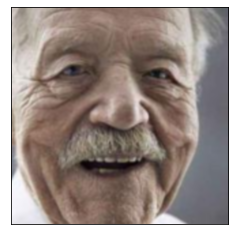

100
0
0


In [65]:
imshow(X[0])
print(y1[0])
print(y2[0])
print(y3[0])

In [37]:
X = X/255

In [66]:
X_train, X_valid, y1_train, y1_valid, y2_train, y2_valid, y3_train, y3_valid = train_test_split(X, y1, y2, y3, test_size=0.25)

In [67]:
X_train = np.array(X_train.tolist())
X_valid = np.array(X_valid.tolist())

## Gender Model

In [21]:
def Convolution(input_tensor,filters):
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)
    return x

def model(input_shape):
      inputs = Input((input_shape))
        
    conv_1= Convolution(inputs,32)
    maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
    conv_2 = Convolution(maxp_1,64)
    maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
    conv_3 = Convolution(maxp_2,128)
    maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
    conv_4 = Convolution(maxp_3,256)
    maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
    flatten= Flatten() (maxp_4)
    dense_1= Dense(64,activation='relu')(flatten)
    drop_1=Dropout(0.2)(dense_1)
    output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
    model = Model(inputs=[inputs], outputs=[output_1])
    model.compile(loss=["binary_crossentropy"], optimizer="Adam",
    metrics=["accuracy"])

      return model

In [22]:
Model=model((48,48,3))

In [23]:
Model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 64)        0   

## Train Model

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
fle_s='gender_detection.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True)
callback_list=[checkpointer,Early_stop]
History=Model.fit(X_train,y2_train,batch_size=64,validation_data=(X_valid,y2_valid),epochs=500,callbacks=callback_list)

Train on 16509 samples, validate on 5504 samples
Epoch 1/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.7248
Epoch 00001: val_loss improved from inf to 0.47318, saving model to gender_detection.h5
16509/16509 [==============================] - 32s 2ms/sample - loss: 0.6142 - accuracy: 0.7251 - val_loss: 0.4732 - val_accuracy: 0.8338
Epoch 2/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8414
Epoch 00002: val_loss improved from 0.47318 to 0.39545, saving model to gender_detection.h5
16509/16509 [==============================] - 7s 444us/sample - loss: 0.4219 - accuracy: 0.8414 - val_loss: 0.3954 - val_accuracy: 0.8681
Epoch 3/500
16384/16509 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8660
Epoch 00003: val_loss improved from 0.39545 to 0.37467, saving model to gender_detection.h5
16509/16509 [==============================] - 7s 430us/sample - loss: 0.3711 - accuracy: 0.8662 - 

Epoch 27/500
16448/16509 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9357
Epoch 00027: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 418us/sample - loss: 0.2354 - accuracy: 0.9356 - val_loss: 0.3001 - val_accuracy: 0.9055
Epoch 28/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9331
Epoch 00028: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 417us/sample - loss: 0.2398 - accuracy: 0.9331 - val_loss: 0.3045 - val_accuracy: 0.9021
Epoch 29/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2342 - accuracy: 0.9363
Epoch 00029: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 416us/sample - loss: 0.2346 - accuracy: 0.9359 - val_loss: 0.3001 - val_accuracy: 0.9044
Epoch 30/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2338 - accuracy: 0.9379
Epoch 00030: val_loss 

Epoch 55/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9474
Epoch 00055: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 422us/sample - loss: 0.2208 - accuracy: 0.9475 - val_loss: 0.3215 - val_accuracy: 0.9064
Epoch 56/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9530
Epoch 00056: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 420us/sample - loss: 0.2111 - accuracy: 0.9529 - val_loss: 0.3325 - val_accuracy: 0.9059
Epoch 57/500
16448/16509 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9524
Epoch 00057: val_loss did not improve from 0.28788
16509/16509 [==============================] - 7s 422us/sample - loss: 0.2106 - accuracy: 0.9524 - val_loss: 0.3267 - val_accuracy: 0.9033
Epoch 58/500
16320/16509 [============================>.] - ETA: 0s - loss: 0.2071 - accuracy: 0.9556
Epoch 00058: val_loss 

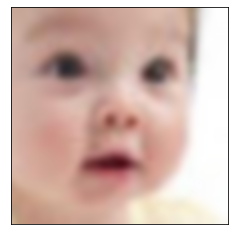

1
[[0.61322176]]


In [36]:
p_id=23
imshow(X_valid[p_id])
print(list(y2_valid)[p_id])
print(model.predict([[X_valid[p_id]]]))

In [37]:
model.evaluate(X_valid,y2_valid)

5504/5504 [==============================] - 2s 404us/sample - loss: 0.2288 - accuracy: 0.9437


[0.22882811205331668, 0.9436773]

In [43]:
predictions=Model.predict(X_valid)

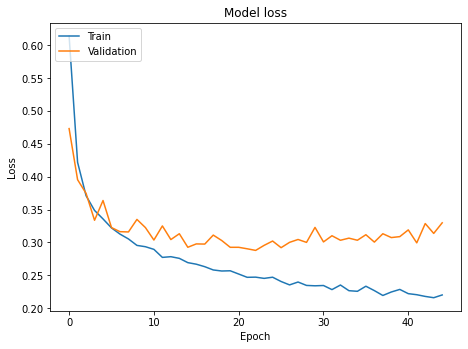

In [50]:
plt.plot(History.history['loss'][:45])
plt.plot(History.history['val_loss'][:45])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

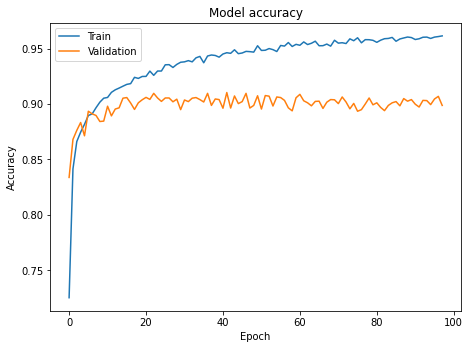

In [52]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [55]:
i=0
pred=[]
while(i<len(predictions)):
    pred.append(int(np.round(predictions[i])))
    i+=1

In [58]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
report=classification_report(y2_valid, pred)
results = confusion_matrix(y2_valid, pred)

In [59]:
print(report)

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2851
           1       0.91      0.90      0.91      2653

    accuracy                           0.91      5504
   macro avg       0.91      0.91      0.91      5504
weighted avg       0.91      0.91      0.91      5504



In [60]:
confusion_matrix(y2_valid, pred)

array([[2630,  221],
       [ 276, 2377]], dtype=int64)

In [63]:
Model.save('gender.h5') 

## Age Model

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
df.head()

,id,face,age,gender,race,file,age_class
0,0,"[[[210, 201, 196], [192, 183, 176], [146, 137,...",100,0,0,100_0_0_20170112213500903.jpg.chip.jpg,3
1,1,"[[[121, 125, 136], [122, 126, 136], [111, 116,...",100,0,0,100_0_0_20170112215240346.jpg.chip.jpg,3
2,2,"[[[231, 235, 241], [153, 165, 188], [98, 116, ...",100,1,0,100_1_0_20170110183726390.jpg.chip.jpg,3
3,3,"[[[78, 82, 93], [78, 82, 93], [78, 82, 93], [7...",100,1,0,100_1_0_20170112213001988.jpg.chip.jpg,3
4,4,"[[[66, 70, 81], [68, 72, 83], [90, 94, 105], [...",100,1,0,100_1_0_20170112213303693.jpg.chip.jpg,3


In [7]:
del df['file']

In [8]:
augmented = []
for i,r in tqdm(df.iterrows()):
    if r['age_class']==1:
        face = np.squeeze(data_augmentation(tf.expand_dims(r['face'], 0)))
        augmented.append({'face':face,'age':r['age'],'age_class':r['age_class']})
        face = np.squeeze(data_augmentation(tf.expand_dims(r['face'], 0)))
        augmented.append({'face':face,'age':r['age'],'age_class':r['age_class']})

22013it [00:09, 2260.46it/s]


In [9]:
df2 = pd.DataFrame(augmented)

In [10]:
df3 = df[['face','age','age_class']]

In [11]:
df3 = df3.append(df2)

In [12]:
np.unique(df3['age_class'],return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([ 2994,  2904, 15381,  2670], dtype=int64))

In [13]:
df3= df3.sample(frac=1).reset_index(drop=True)

In [14]:
X = df3['face']
y = df3['age']

In [15]:
X = X/255

In [16]:
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.25)

In [17]:
X_train = np.array(X_train.tolist())
X_valid = np.array(X_valid.tolist())

In [18]:
def Convolution(input_tensor,filters):
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)
    return x

def model(input_shape):
        inputs = Input((input_shape))
        conv_1= Convolution(inputs,32)
        maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
        conv_2 = Convolution(maxp_1,64)
        maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
        conv_3 = Convolution(maxp_2,128)
        maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
        conv_4 = Convolution(maxp_3,256)
        maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
        flatten= Flatten() (maxp_4)
        dense_2= Dense(64,activation='relu')(flatten)
        drop_2=Dropout(0.2)(dense_2)
        output_2= Dense(1,activation="relu",name='age_out')(drop_2)
        model = Model(inputs=[inputs], outputs=[output_2])
        model.compile(loss=["mae"], optimizer="Adam")
        return model

In [19]:
Model=model((48,48,3))
Model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)       

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
fle_s='age_detection2.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True)
callback_list=[checkpointer,Early_stop]
History=Model.fit(X_train,y_train,batch_size=64,validation_data=(X_valid,y_valid),epochs=500,callbacks=callback_list,shuffle=True)

Epoch 1/500
281/281 [==============================] - ETA: 0s - loss: 16.1089
Epoch 00001: val_loss improved from inf to 15.67259, saving model to age_detection2.h5
281/281 [==============================] - 15s 52ms/step - loss: 16.1089 - val_loss: 15.6726
Epoch 2/500
279/281 [============================>.] - ETA: 0s - loss: 13.1173
Epoch 00002: val_loss improved from 15.67259 to 12.58959, saving model to age_detection2.h5
281/281 [==============================] - 7s 25ms/step - loss: 13.1042 - val_loss: 12.5896
Epoch 3/500
280/281 [============================>.] - ETA: 0s - loss: 10.7082
Epoch 00003: val_loss did not improve from 12.58959
281/281 [==============================] - 7s 24ms/step - loss: 10.7110 - val_loss: 13.3922
Epoch 4/500
280/281 [============================>.] - ETA: 0s - loss: 9.8199
Epoch 00004: val_loss improved from 12.58959 to 12.16700, saving model to age_detection2.h5
281/281 [==============================] - 7s 25ms/step - loss: 9.8156 - val_loss: 12

281/281 [==============================] - 7s 25ms/step - loss: 6.1694 - val_loss: 7.2678
Epoch 37/500
281/281 [==============================] - ETA: 0s - loss: 6.1161
Epoch 00037: val_loss did not improve from 7.26780
281/281 [==============================] - 7s 24ms/step - loss: 6.1161 - val_loss: 7.8367
Epoch 38/500
279/281 [============================>.] - ETA: 0s - loss: 6.1540
Epoch 00038: val_loss did not improve from 7.26780
281/281 [==============================] - 7s 24ms/step - loss: 6.1516 - val_loss: 8.1815
Epoch 39/500
280/281 [============================>.] - ETA: 0s - loss: 6.0896
Epoch 00039: val_loss did not improve from 7.26780
281/281 [==============================] - 7s 24ms/step - loss: 6.0937 - val_loss: 8.2926
Epoch 40/500
279/281 [============================>.] - ETA: 0s - loss: 6.0241
Epoch 00040: val_loss did not improve from 7.26780
281/281 [==============================] - 7s 24ms/step - loss: 6.0294 - val_loss: 8.1764
Epoch 41/500
278/281 [========

280/281 [============================>.] - ETA: 0s - loss: 5.4333
Epoch 00110: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.4320 - val_loss: 7.5024
Epoch 111/500
281/281 [==============================] - ETA: 0s - loss: 5.4374
Epoch 00111: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.4374 - val_loss: 7.1936
Epoch 112/500
281/281 [==============================] - ETA: 0s - loss: 5.3934
Epoch 00112: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.3934 - val_loss: 7.2505
Epoch 113/500
279/281 [============================>.] - ETA: 0s - loss: 5.3991
Epoch 00113: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.4017 - val_loss: 7.7754
Epoch 114/500
281/281 [==============================] - ETA: 0s - loss: 5.3576
Epoch 00114: val_loss did not improve from 6.96209

280/281 [============================>.] - ETA: 0s - loss: 5.2382
Epoch 00147: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.2358 - val_loss: 7.2535
Epoch 148/500
279/281 [============================>.] - ETA: 0s - loss: 5.1500
Epoch 00148: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.1528 - val_loss: 8.1314
Epoch 149/500
281/281 [==============================] - ETA: 0s - loss: 5.2891
Epoch 00149: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.2891 - val_loss: 7.3905
Epoch 150/500
279/281 [============================>.] - ETA: 0s - loss: 5.2060
Epoch 00150: val_loss did not improve from 6.96209
281/281 [==============================] - 7s 24ms/step - loss: 5.2102 - val_loss: 7.6138
Epoch 151/500
280/281 [============================>.] - ETA: 0s - loss: 5.2575
Epoch 00151: val_loss did not improve from 6.96209

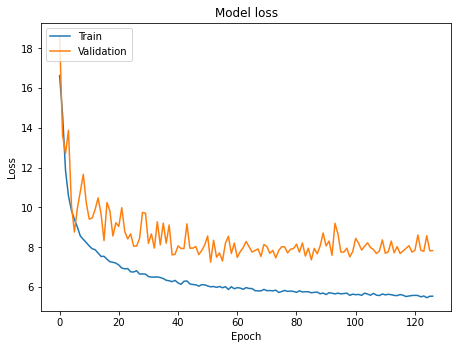

In [34]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

In [21]:
Model.evaluate(X_valid,y_valid)

188/188 [==============================] - 1s 5ms/step - loss: 6.9621


6.962091445922852

In [22]:
predictions=Model.predict(X_valid)
i=0
pred=[]
while(i<len(predictions)):
    pred.append(int(np.round(predictions[i])))
    i+=1

In [23]:
df2 = pd.DataFrame({'label':y_valid,'prediction':pred})

In [45]:
bins = [0, 18, 59, np.inf]
names = [0, 1, 2]

df2['label'] = pd.cut(df2['label'], bins, labels=names)
df2['prediction'] = pd.cut(df2['prediction'], bins, labels=names)

In [46]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
print(classification_report(df2['label'], df2['prediction']))

              precision    recall  f1-score   support

           0       0.97      0.87      0.91       966
           1       0.92      0.98      0.95      3849
           2       0.91      0.71      0.80       689

    accuracy                           0.93      5504
   macro avg       0.93      0.85      0.89      5504
weighted avg       0.93      0.93      0.92      5504



In [47]:
confusion_matrix(df2['label'], df2['prediction'])

array([[ 836,  130,    0],
       [  29, 3771,   49],
       [   0,  201,  488]], dtype=int64)

In [26]:
Model.save('age.h5') 

# Race Model

In [6]:
df2 = df[['race','file']]

In [37]:
for i in np.unique(df['race']):
    os.makedirs("data/races/"+str(i))

In [7]:
df2_train, df2_test = train_test_split(df2, test_size=0.25)

In [24]:
from shutil import copyfile
for i,r in tqdm(df2_train.iterrows()):
    f = 'data/'+r['file']
    to = 'data/races/train/'+str(r['race'])+'/'+r['file']
    copyfile(f,to)

16509it [04:43, 58.18it/s]



In [25]:
from shutil import copyfile
for i,r in tqdm(df2_test.iterrows()):
    f = 'data/'+r['file']
    to = 'data/races/test/'+str(r['race'])+'/'+r['file']
    copyfile(f,to)

5504it [01:19, 69.25it/s]



In [4]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [6]:
train_dir = 'data/races/train/'
validation_dir = 'data/races/test/'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 16509 files belonging to 4 classes.


In [7]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 5504 files belonging to 4 classes.


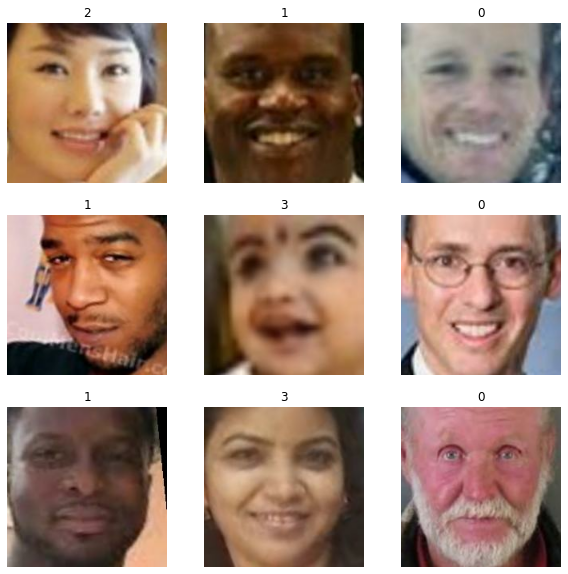

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 138
Number of test batches: 34


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

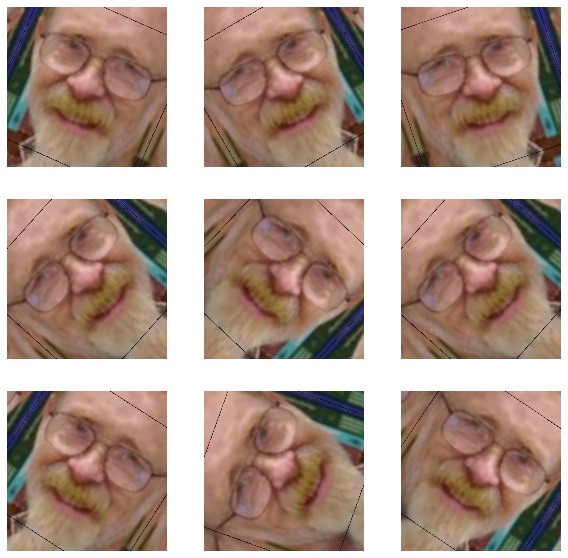

In [13]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [50]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [51]:
base_model.trainable = False

In [52]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [83]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [84]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [85]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [86]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
len(model.trainable_variables)


2

In [88]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

138/138 [==============================] - 7s 54ms/step - loss: 1.5966 - accuracy: 0.2362


In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint
fle_s='race_detection2.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True)
callback_list=[checkpointer,Early_stop]
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset,callbacks=callback_list)

Epoch 1/100
515/516 [============================>.] - ETA: 0s - loss: 1.3723 - accuracy: 0.4367
Epoch 00001: val_loss improved from inf to 1.12040, saving model to race_detection2.h5
516/516 [==============================] - 38s 73ms/step - loss: 1.3720 - accuracy: 0.4368 - val_loss: 1.1204 - val_accuracy: 0.5256
Epoch 2/100
516/516 [==============================] - ETA: 0s - loss: 1.1219 - accuracy: 0.5323
Epoch 00002: val_loss improved from 1.12040 to 1.01618, saving model to race_detection2.h5
516/516 [==============================] - 38s 74ms/step - loss: 1.1219 - accuracy: 0.5323 - val_loss: 1.0162 - val_accuracy: 0.5974
Epoch 3/100
516/516 [==============================] - ETA: 0s - loss: 1.0431 - accuracy: 0.5713
Epoch 00003: val_loss improved from 1.01618 to 0.95665, saving model to race_detection2.h5
516/516 [==============================] - 38s 75ms/step - loss: 1.0431 - accuracy: 0.5713 - val_loss: 0.9567 - val_accuracy: 0.6202
Epoch 4/100
516/516 [====================

516/516 [==============================] - 39s 75ms/step - loss: 0.8339 - accuracy: 0.6646 - val_loss: 0.8266 - val_accuracy: 0.6676
Epoch 28/100
516/516 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.6664
Epoch 00028: val_loss did not improve from 0.82662
516/516 [==============================] - 38s 74ms/step - loss: 0.8324 - accuracy: 0.6664 - val_loss: 0.8281 - val_accuracy: 0.6680
Epoch 29/100
516/516 [==============================] - ETA: 0s - loss: 0.8346 - accuracy: 0.6671
Epoch 00029: val_loss did not improve from 0.82662
516/516 [==============================] - 38s 74ms/step - loss: 0.8346 - accuracy: 0.6671 - val_loss: 0.8348 - val_accuracy: 0.6655
Epoch 30/100
516/516 [==============================] - ETA: 0s - loss: 0.8314 - accuracy: 0.6681
Epoch 00030: val_loss did not improve from 0.82662
516/516 [==============================] - 38s 74ms/step - loss: 0.8314 - accuracy: 0.6681 - val_loss: 0.8322 - val_accuracy: 0.6698
Epoch 31/100
516/516 

Epoch 56/100
516/516 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6765
Epoch 00056: val_loss did not improve from 0.80970
516/516 [==============================] - 38s 74ms/step - loss: 0.8152 - accuracy: 0.6765 - val_loss: 0.8150 - val_accuracy: 0.6780
Epoch 57/100
516/516 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.6754
Epoch 00057: val_loss did not improve from 0.80970
516/516 [==============================] - 39s 76ms/step - loss: 0.8162 - accuracy: 0.6754 - val_loss: 0.8302 - val_accuracy: 0.6687
Epoch 58/100
516/516 [==============================] - ETA: 0s - loss: 0.8193 - accuracy: 0.6768
Epoch 00058: val_loss did not improve from 0.80970
516/516 [==============================] - 39s 75ms/step - loss: 0.8193 - accuracy: 0.6768 - val_loss: 0.8179 - val_accuracy: 0.6796
Epoch 59/100
516/516 [==============================] - ETA: 0s - loss: 0.8208 - accuracy: 0.6730
Epoch 00059: val_loss did not improve from 0.80970
516/5

516/516 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.6771
Epoch 00085: val_loss did not improve from 0.80970
516/516 [==============================] - 39s 76ms/step - loss: 0.8148 - accuracy: 0.6771 - val_loss: 0.8221 - val_accuracy: 0.6721
Epoch 86/100
516/516 [==============================] - ETA: 0s - loss: 0.8108 - accuracy: 0.6773
Epoch 00086: val_loss did not improve from 0.80970
516/516 [==============================] - 40s 78ms/step - loss: 0.8108 - accuracy: 0.6773 - val_loss: 0.8151 - val_accuracy: 0.6837
Epoch 87/100
516/516 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.6808
Epoch 00087: val_loss did not improve from 0.80970
516/516 [==============================] - 39s 77ms/step - loss: 0.8089 - accuracy: 0.6808 - val_loss: 0.8206 - val_accuracy: 0.6764
Epoch 88/100
516/516 [==============================] - ETA: 0s - loss: 0.8059 - accuracy: 0.6795
Epoch 00088: val_loss did not improve from 0.80970
516/516 [=========

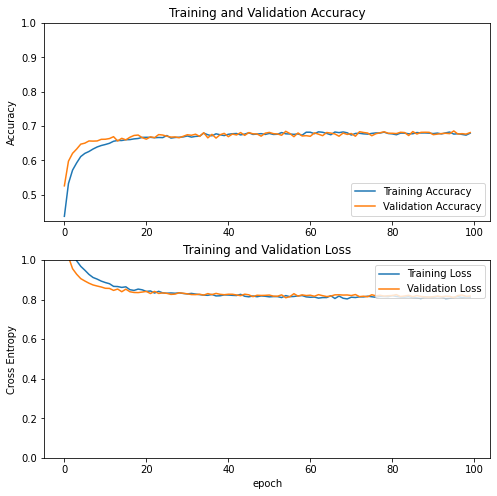

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [93]:
loss, accuracy = model.evaluate(test_dataset)

34/34 [==============================] - 2s 53ms/step - loss: 0.8226 - accuracy: 0.6792


Predictions:
 [0 0 0 2 2 1 0 0 0 1 0 0 0 0 3 0 0 1 0 2 2 0 0 1 0 1 1 1 3 0 0 0]
Labels:
 [0 0 0 2 1 1 3 0 0 0 0 3 0 0 3 0 3 1 0 2 2 3 0 1 0 1 1 2 3 0 1 0]


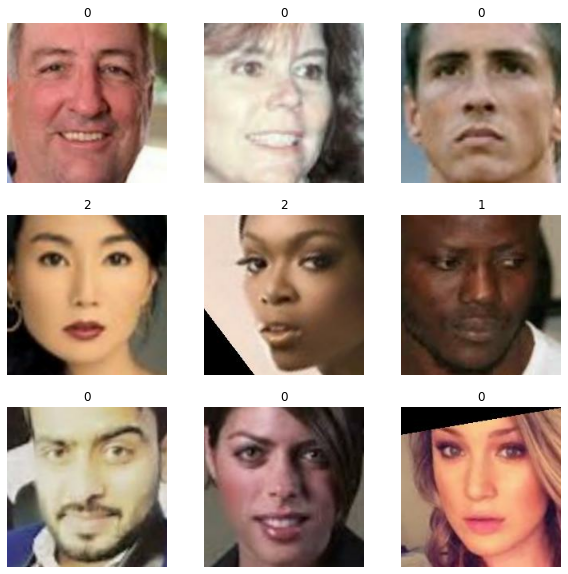

In [94]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions,axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [95]:
base_model.trainable = True

In [96]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [97]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [98]:
len(model.trainable_variables)


58

In [101]:
fine_tune_epochs = 50
total_epochs =  100 + fine_tune_epochs
fle_s='race_detection2_ft.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=75, monitor='val_loss',restore_best_weights=True)
callback_list=[checkpointer,Early_stop]
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callback_list)

Epoch 100/150
516/516 [==============================] - ETA: 0s - loss: 0.7885 - accuracy: 0.6851
Epoch 00100: val_loss improved from inf to 0.79674, saving model to race_detection2_ft.h5
516/516 [==============================] - 56s 108ms/step - loss: 0.7885 - accuracy: 0.6851 - val_loss: 0.7967 - val_accuracy: 0.6877
Epoch 101/150
516/516 [==============================] - ETA: 0s - loss: 0.7179 - accuracy: 0.7163
Epoch 00101: val_loss improved from 0.79674 to 0.71690, saving model to race_detection2_ft.h5
516/516 [==============================] - 55s 107ms/step - loss: 0.7179 - accuracy: 0.7163 - val_loss: 0.7169 - val_accuracy: 0.7192
Epoch 102/150
516/516 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7364
Epoch 00102: val_loss improved from 0.71690 to 0.67189, saving model to race_detection2_ft.h5
516/516 [==============================] - 56s 108ms/step - loss: 0.6757 - accuracy: 0.7364 - val_loss: 0.6719 - val_accuracy: 0.7493
Epoch 103/150
516/516 [

Epoch 127/150
516/516 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8662
Epoch 00127: val_loss did not improve from 0.49831
516/516 [==============================] - 55s 106ms/step - loss: 0.3672 - accuracy: 0.8662 - val_loss: 0.4988 - val_accuracy: 0.8184
Epoch 128/150
516/516 [==============================] - ETA: 0s - loss: 0.3599 - accuracy: 0.8693
Epoch 00128: val_loss did not improve from 0.49831
516/516 [==============================] - 55s 106ms/step - loss: 0.3599 - accuracy: 0.8693 - val_loss: 0.5295 - val_accuracy: 0.8080
Epoch 129/150
516/516 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.8710
Epoch 00129: val_loss did not improve from 0.49831
516/516 [==============================] - 55s 106ms/step - loss: 0.3574 - accuracy: 0.8710 - val_loss: 0.5189 - val_accuracy: 0.8102
Epoch 130/150
516/516 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8731
Epoch 00130: val_loss did not improve from 0.4983

In [102]:
loss, accuracy = model.evaluate(test_dataset)

34/34 [==============================] - 2s 53ms/step - loss: 0.5445 - accuracy: 0.8290


Predictions:
 [0 1 0 0 0 2 0 1 3 3 2 1 2 1 3 0 0 1 0 0 0 0 0 0 0 1 0 3 0 3 0 3]
Labels:
 [0 1 0 2 0 2 0 1 3 3 2 1 2 1 3 1 0 1 0 0 0 0 0 0 0 3 0 3 0 0 0 1]


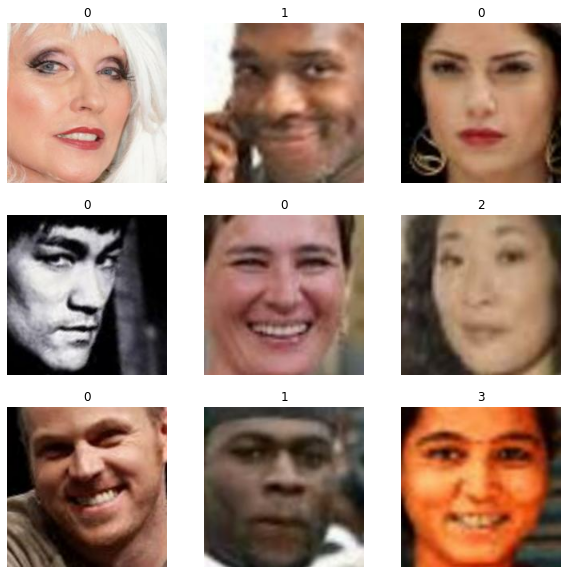

In [103]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions,axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [104]:
fine_tune_epochs = 50
total_epochs =  150 + fine_tune_epochs
fle_s='race_detection2_ft_2.h5'
checkpointer = ModelCheckpoint(fle_s, monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False, mode='auto',save_freq='epoch')
Early_stop=tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss',restore_best_weights=True)
callback_list=[checkpointer,Early_stop]
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callback_list)

Epoch 100/200
516/516 [==============================] - ETA: 0s - loss: 0.2648 - accuracy: 0.9053
Epoch 00100: val_loss improved from inf to 0.58159, saving model to race_detection2_ft_2.h5
516/516 [==============================] - 54s 105ms/step - loss: 0.2648 - accuracy: 0.9053 - val_loss: 0.5816 - val_accuracy: 0.8023
Epoch 101/200
516/516 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9074
Epoch 00101: val_loss improved from 0.58159 to 0.47513, saving model to race_detection2_ft_2.h5
516/516 [==============================] - 55s 106ms/step - loss: 0.2560 - accuracy: 0.9074 - val_loss: 0.4751 - val_accuracy: 0.8329
Epoch 102/200
516/516 [==============================] - ETA: 0s - loss: 0.2590 - accuracy: 0.9084
Epoch 00102: val_loss did not improve from 0.47513
516/516 [==============================] - 54s 105ms/step - loss: 0.2590 - accuracy: 0.9084 - val_loss: 0.5284 - val_accuracy: 0.8148
Epoch 103/200
516/516 [==============================] - ETA: 

Epoch 129/200
516/516 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9345
Epoch 00129: val_loss did not improve from 0.47513
516/516 [==============================] - 54s 105ms/step - loss: 0.1856 - accuracy: 0.9345 - val_loss: 0.5602 - val_accuracy: 0.8159
Epoch 130/200
516/516 [==============================] - ETA: 0s - loss: 0.1825 - accuracy: 0.9356
Epoch 00130: val_loss did not improve from 0.47513
516/516 [==============================] - 54s 105ms/step - loss: 0.1825 - accuracy: 0.9356 - val_loss: 0.5543 - val_accuracy: 0.8188
Epoch 131/200
516/516 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9344
Epoch 00131: val_loss did not improve from 0.47513
516/516 [==============================] - 55s 106ms/step - loss: 0.1821 - accuracy: 0.9344 - val_loss: 0.5517 - val_accuracy: 0.8213


Predictions:
 [0 1 1 1 1 1 0 2 0 1 2 2 3 3 3 2 0 0 3 1 0 1 0 1 1 0 1 3 3 1 1 1]
Labels:
 [0 1 1 1 1 1 0 2 3 1 2 2 3 0 0 2 0 0 0 1 2 1 0 1 1 0 1 3 3 1 0 1]


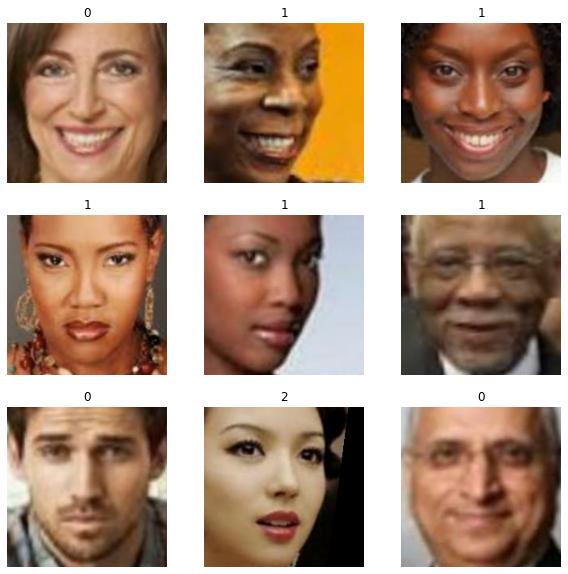

In [105]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = np.argmax(predictions,axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [108]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

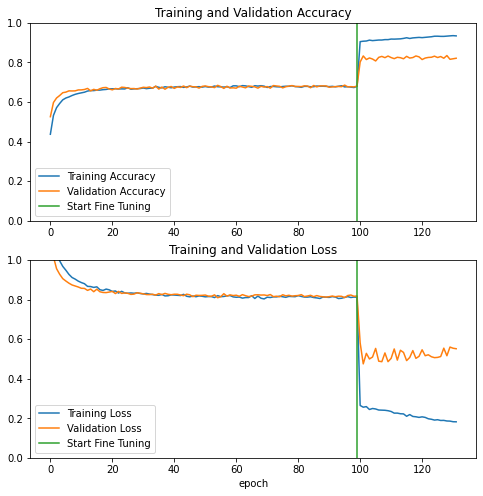

In [114]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([99,99],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([99,99],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [122]:
model.evaluate(test_dataset)

34/34 [==============================] - 2s 53ms/step - loss: 0.4861 - accuracy: 0.8364


[0.4861345887184143, 0.8363970518112183]

In [68]:
predictions_r = model_race.predict(X_valid)

predictions_r = np.argmax(predictions_r,axis=1)

In [70]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
print(classification_report(y3_valid,predictions_r))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      2558
           1       0.87      0.89      0.88      1132
           2       0.90      0.78      0.83       833
           3       0.78      0.87      0.82       981

    accuracy                           0.87      5504
   macro avg       0.86      0.86      0.86      5504
weighted avg       0.88      0.87      0.87      5504



In [71]:
confusion_matrix(y3_valid,predictions_r)

array([[2305,   56,   61,  136],
       [  48, 1010,    9,   65],
       [ 111,   27,  650,   45],
       [  60,   68,    4,  849]], dtype=int64)